# **Exploratory PM2.5 Visualization App**

<!-- Author: Rob Hendrickson

This project utilizes the power of Python to explore interpolation methods as they apply to local volatile organic compound (VOC) readings. The data to be used is from the Minneapolis Health Department’s 2016 seasonal neighborhood study. There are often extreme readings nearby rather moderate readings, so Ordinary Kriging interpolation produces unrealistic results.

The data was queried for the most prominent VOCs (Benzene & Naphthalene) and divided by season. A regular grid was made over Minneapolis with 100 x 100m resolution, then the observations were iteratively interpolated using the deterministic Radial Based Function (RBF) method. Reasonable parameters were found and then a user interface was developed to allow for tweaking of the parameters using `ipywidgets`. The results can be compared across seasons using the `interp_all_seasons()` function and/or saved as geotiffs using `Rasterio`. 

**Data Sources:** Jenni Lansing (Minneapolis Health Department) - 2016 Neighborhood Air Quality Study

https://www2.minneapolismn.gov/media/content-assets/www2-documents/government/Air-Quality-Study-Long-Report-.pdf -->

In [3]:
# Import Packages & Libraries

import os

# Analysis Libraries

import numpy as np # For working with Arrays
import pandas as pd # Data Manipulation
import geopandas as gpd # Spatial Data Manipulation
from scipy import interpolate as interp # # different interpolators
import rasterio # Rasters
from rasterio.transform import Affine

# Visualization Libraries

import matplotlib.pyplot as plt # Basic Plotting
plt.style.use('ggplot') # 
import seaborn as sns # Statistical Plotting
import contextily # Base Map Visualization
import mapclassify as mc # Classifying Maps

# Interaction

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import datetime # Time

# Silence Warnings

import warnings
warnings.filterwarnings('ignore')

In [70]:
help(display)

Help on function display in module IPython.core.display_functions:

display(*objs, include=None, exclude=None, metadata=None, transient=None, display_id=None, raw=False, clear=False, **kwargs)
    Display a Python object in all frontends.
    
    By default all representations will be computed and sent to the frontends.
    Frontends can decide which representation is used and how.
    
    In terminal IPython this will be similar to using :func:`print`, for use in richer
    frontends see Jupyter notebook examples with rich display logic.
    
    Parameters
    ----------
    *objs : object
        The Python objects to display.
    raw : bool, optional
        Are the objects to be displayed already mimetype-keyed dicts of raw display data,
        or Python objects that need to be formatted before display? [default: False]
    include : list, tuple or set, optional
        A list of format type strings (MIME types) to include in the
        format data dict. If this is set *only* 

# Load Data 

In [4]:
datapath = os.path.join('..', '..', 'Data')

## Storage for datasets

data_dict = {}

# Boundary - From MetroCouncil 2010 CTU boundaries

path = os.path.join(datapath, 'mpls_boundary.geojson')
data_dict['mpls'] = gpd.read_file(path)

# Traffic

path = os.path.join(datapath, 'mpls_aadt.geojson')
data_dict['aadt'] = gpd.read_file(path)

# Emissions
## Facilitites
path = os.path.join(datapath, 'mpca_facilities.geojson')
data_dict['facs'] = gpd.clip(gpd.read_file(path), data_dict['mpls'].buffer(1000))
## Emissions
path = os.path.join(datapath, 'MPCA_Permitted_Emissions.csv')
data_dict['emissions'] = pd.read_csv(path)

# Health

path = os.path.join(datapath, 'mpls_health.geojson')
data_dict['health'] = gpd.read_file(path)

# Demographics

path = os.path.join(datapath, 'mpls_demographics2019.geojson')
data_dict['demo'] = gpd.read_file(path)

# PurpleAir Stations

path = os.path.join(datapath, 'PurpleAir_Stations.geojson')
stations = gpd.read_file(path)
stations['sensor_index'] = stations.sensor_index.astype(int)
data_dict['stations'] = stations

# PM2.5 Readings and Daily Summaries - From Purple Air

# Results are in micrograms/meter^3
# Mn Health benchmarks found at: https://www.health.state.mn.us/communities/environment/risk/guidance/air/table.html

path = os.path.join(datapath, 'daily_summaries.csv')
daily_sums = pd.read_csv(path)
daily_sums['date'] = pd.to_datetime(daily_sums.date)
data_dict['daily_sums'] = daily_sums

# Spikes

path = os.path.join(datapath, 'all_spikes.csv')
spikes = pd.read_csv(path)
spikes['timestamp'] = pd.to_datetime(spikes.timestamp)
data_dict['spikes'] = spikes

In [5]:
daily_sums.columns

Index(['sensor_index', 'date', 'n_observations', 'humidity_fullDay_mean',
       'temperature_fullDay_mean', 'pressure_fullDay_mean',
       'pm25_fullDay_mean', 'pm25_fullDay_min', 'pm25_fullDay_minTime',
       'pm25_fullDay_max', 'pm25_fullDay_maxTime', 'pm25_fullDay_std',
       'pm25_fullDay_minutesAbove12ug', 'pm25_morningRush_mean',
       'pm25_morningRush_min', 'pm25_morningRush_minTime',
       'pm25_morningRush_max', 'pm25_morningRush_maxTime',
       'pm25_morningRush_std', 'pm25_eveningRush_mean', 'pm25_eveningRush_min',
       'pm25_eveningRush_minTime', 'pm25_eveningRush_max',
       'pm25_eveningRush_maxTime', 'pm25_eveningRush_std',
       'pm25_daytimeAmbient_mean', 'pm25_daytimeAmbient_min',
       'pm25_daytimeAmbient_minTime', 'pm25_daytimeAmbient_max',
       'pm25_daytimeAmbient_maxTime', 'pm25_daytimeAmbient_std',
       'pm25_nighttimeAmbient_mean', 'pm25_nighttimeAmbient_min',
       'pm25_nighttimeAmbient_minTime', 'pm25_nighttimeAmbient_max',
       'pm25_ni

## Select the dates to summarize

In [53]:
# Months

full_first_date = min(daily_sums.date)
full_last_date = max(daily_sums.date)
full_datelist = pd.date_range(start = full_first_date, 
                         end = full_last_date,
                        normalize = True) # List of the dates in dataset

monthlist = full_datelist.to_period('M').unique() # Unique Months
options = [(date.strftime(' %b %Y '), date) for date in monthlist]
index = (0, len(options)-1)

month_range_slider = widgets.SelectionRangeSlider(
    options=options,
    index=index,
    description='Select Months for analysis',
    orientation='horizontal',
    layout={'width': '100%', 'description_width':'initial'}
)

# Dates to summarize

datelist = pd.date_range(start = full_first_date, 
                         end = full_last_date,
                        normalize = True)

options = [(date.strftime(' %d %b %Y '), date) for date in datelist]
index = (0, len(options)-1)

date_range_slider = widgets.SelectionRangeSlider(
    options=options,
    index=index,
    description='Dates',
    orientation='horizontal',
    layout={'width': '100%'}
)

def update_month_range(*args):
    
    first_period, last_period = month_range_slider.value

    d1 = first_period.start_time # First date in range
    dn = last_period.end_time # Last date in range


    datelist = pd.date_range(start = d1, 
                             end = dn,
                            normalize = True)
    
    date_range_slider.options = [(date.strftime(' %d %b %Y '), date) for date in datelist]
    date_range_slider.index = (0, len(options)-1)

month_range_slider.observe(update_month_range, 'value')

In [54]:
# User Interface

date_ui = widgets.VBox([month_range_slider, date_range_slider])

display(date_ui)

In [62]:
# Se;ect the date

def get_select_sensors_gdf(date_range_slider_value):

    # Final date range

    first_day, last_day = date_range_slider_value

    focus_dates = pd.date_range(start = first_day, 
                             end = last_day,
                            normalize = True)

    
        # Select the data

    focus_obs = daily_sums[(daily_sums.date >= first_day) &
                             (daily_sums.date <= last_day)] # Focus by dates

    length_of_dates = len(focus_obs.date.unique())

    # Select those with more than 120 observations

    select_obs = focus_obs[focus_obs.n_observations > 120]

    # GroupBy sensor_index

    grouped_obs = select_obs.groupby('sensor_index').agg({'date':'count',
                                                        'pm25_fullDay_mean':'mean',
                                                        'pm25_morningRush_mean':'mean',
                                                        'pm25_eveningRush_mean':'mean',
                                                        'pm25_daytimeAmbient_mean':'mean',
                                                        'pm25_nighttimeAmbient_mean':'mean',
                                                        'pm25_fullDay_minutesAbove12ug':'sum'
                                           }
                                          ).reset_index()

    # Select those with all dates

    select_sensors = grouped_obs[grouped_obs.date == length_of_dates]

    # Merge with stations

    select_sensors_gdf = stations.merge(select_sensors, left_on = 'sensor_index', right_on = 'sensor_index', how='left')
    
    return select_sensors_gdf

## Make the interactive plot app

In [78]:
def make_minutesAbove_plot(select_sensors_gdf,
                           firstday_str,
                           lastday_str,
                           cmap,
                            k,
                            scheme,
                            alpha,
                            to_save,
                            savename):

    '''
    select_sensors_gdf: The GeoDataFrame with the station data/information for the selected dates
    first_day_str: string of first date
    lastday_str: string of last date
    cmap: colormap for plot
    k: number of classifications
    scheme: classification scheme
    alpha: dot opacity (In percent)
    to_save: Boolean, save or no
    savename: Name to save figure (without .png)
    '''

                                

    # initialize figure and plot
                                
    f, ax = plt.subplots(1, 
                         figsize = (10,8)
                        )

    # Legend axes

    # from mpl_toolkits.axes_grid1 import make_axes_locatable
                                
    # divider = make_axes_locatable(ax)

    # cax = divider.append_axes("right", size="5%", pad=0.1)


    plot_df = select_sensors_gdf.copy().sort_values(by = 'pm25_fullDay_minutesAbove12ug',
                                   na_position='first'
                                  )
#     values = plot_df.pm25_fullDay_minutesAbove12ug.values
#     nan_idx = plot_df.pm25_fullDay_minutesAbove12ug.isnull()
#     binning = mc.classify(np.asarray(values[~nan_idx]), scheme, k=5)
    
#     print(binning)
    
    art = plot_df.plot(column = 'pm25_fullDay_minutesAbove12ug',
                                  ax = ax,
                            cmap = cmap,
                            k = k,
                                  edgecolor = 'black',
                                  linewidth = .25,
                                markersize = 75,
                            alpha = (100-alpha)/100, 
                            scheme = scheme, # Classification scheme
                            legend = True,
                            # cax = cax,
                            missing_kwds={
                            "color": "grey",
                            "label": "Not enough\nObservations"
                            }
                                                     )

                                

    # Add basemap
    
    contextily.add_basemap(
                ax,
                crs=select_sensors_gdf.crs,
                source=contextily.providers.CartoDB.Positron
            )
    
    # Remove axes
    
    ax.set_axis_off()

    # Clean up legend
    
    leg = art.get_legend()
    
    # Change label have thousands comma-separated and breaks dash-separated
    for lbl in leg.get_texts():
        label_text = lbl.get_text()
        if label_text != "Not enough\nObservations":
            lower = label_text.split(', ')[0]
            upper = label_text.split(', ')[1]
            new_text = f'{float(lower):,.0f} - {float(upper):,.0f}'
            lbl.set_text(new_text)
    leg.set_title('Minutes') # Legend title
    leg._loc = (.75,.8) # Change location
    
        # Title
    
    f.suptitle(f"Minutes above 12 $micrograms/meter^3$\n\n({firstday_str} - {lastday_str})")

            # Save
    f.tight_layout()
    if to_save:
   
        plt.savefig(f'{savename}.png', dpi = 300)

                                # PResent
    plt.show()

In [57]:
# Visualization Widgets

# Colormap

cmaps = ['Reds', 'Oranges', 'Greys', 'PuRd', 'PuBu', 'viridis', 'cividis', 'inferno_r', 'magma_r']

cmap_widget = widgets.Dropdown(value = 'Reds',
                            options = cmaps,
                            description = 'Colormap',
                            style = {'description_width':'initial'}
                        ) # Function

# Number of Classifications

k_widget = widgets.IntSlider(value = 5,
                                     min = 3,
                                     max = 7,
                                     step = 1,
                                     description = 'Number of Classifications:',
                                     style = {'description_width':'initial'}) # Number of Neighbors

# Classification Scheme 

schemes = ['equalinterval', 'fisherjenks', 'naturalbreaks', 'quantiles', 'percentiles']

scheme_widget = widgets.Dropdown(value = 'equalinterval',
                            options = schemes,
                            description = 'Classification Scheme',
                            style = {'description_width':'initial'}
                        )

# Dot Opacity

alpha_widget = widgets.IntSlider(min = 0,
                             max = 100,
                             step = 1,
                             value = 0,
                             description = 'Dot Opacity (%)',
                            style = {'description_width':'initial'})

plot_ui = widgets.VBox([cmap_widget,
                   k_widget,
                   scheme_widget,
                   alpha_widget]) # User Interface

In [58]:
# Save Widgets

savename_widget = widgets.Text(
                            value = 'Insert Title Here',
                            description = 'Savename:'
)

save_widget = widgets.Checkbox(value = False,
                               description = 'Save?') # Save?

save_ui = widgets.VBox([savename_widget, save_widget]) # User interface

In [60]:
# User Interface

ui = widgets.VBox([date_ui, widgets.HBox([plot_ui, save_ui])]) # Final UI

display(ui)

In [61]:
help(make_minutesAbove_plot)

Help on function make_minutesAbove_plot in module __main__:

make_minutesAbove_plot(select_sensors_gdf, firstday_str, lastday_str, cmap, k, scheme, alpha, to_save, savename)
    select_sensors_gdf: The GeoDataFrame with the station data/information for the selected dates
    first_day_str: string of first date
    lastday_str: string of last date
    cmap: colormap for plot
    k: number of classifications
    scheme: classification scheme
    alpha: dot opacity (In percent)
    to_save: Boolean, save or no
    savename: Name to save figure (without .png)



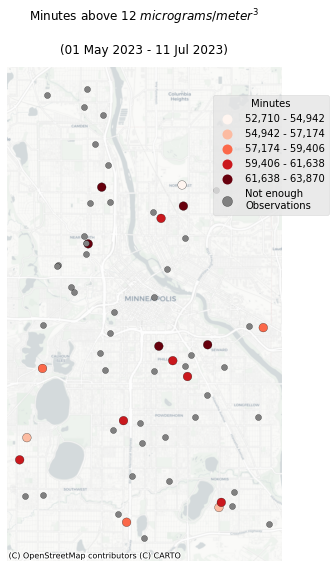

In [31]:
make_minutesAbove_plot(select_sensors_gdf,
                       first_day.date().strftime('%d %b %Y'),
                       last_day.date().strftime('%d %b %Y'),
                       cmap_widget.value,
                       k_widget.value,
                       scheme_widget.value,
                       alpha_widget.value,
                       save_widget.value,
                       savename_widget.value)

In [79]:
# Make app - should explore interact_manual for this...

def interact_fct(date_range_slider_value, cmap, k, scheme, alpha, to_save, savename):
    
    select_sensors_gdf = get_select_sensors_gdf(date_range_slider_value)
    
    firstday, lastday = date_range_slider_value
    firstday_str = firstday.date().strftime('%d %b %Y')
    lastday_str = lastday.date().strftime('%d %b %Y')
    
    if len(select_sensors_gdf.dropna()) > 1:
    
        make_minutesAbove_plot(select_sensors_gdf, firstday_str, lastday_str, 
                               cmap, k, scheme, alpha, to_save, savename)
    
    else:
        
        print('Not enough data')
    
interactive_plot = widgets.interactive_output(interact_fct,
                                          {'date_range_slider_value':date_range_slider,
                                           'cmap':cmap_widget,
                                           'k':k_widget,
                                           'scheme':scheme_widget,
                                           'alpha':alpha_widget,
                                           'to_save':save_widget,
                                           'savename':savename_widget
                                          })  
   

display(ui, interactive_plot) # display

Output()